<a href="https://colab.research.google.com/github/TJhon/lanchain_curso/blob/day3/Pinecone/facial_similarity_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install deepface pinecone-client tqdm -q

# Facial Similarity Search

In this lesson, we will explore the age-old question of which parent a child resembles the most. We will answer this question using vector embeddings and apply it to a freely available image dataset, particularly one featuring the British royal family. Our goal is to determine if Prince William looks more like King Charles or Princess Diana. This process is simple and extensible enough for you to try on your own family pictures.

We'll develop a facial similarity search system to determine which parent looks most like their child. We'll take a father, a mother, and one child, and assess whether the child resembles the father or the mother more. The determination of resemblance will be based on the highest average score between each parent and child.

## Setup

To achieve this, we'll use the DeepFace open-source library, which contains a Facenet model with embeddings that are 128 dimensions wide. Let's start by suppressing warnings and importing necessary libraries into the notebook. Then, we'll retrieve our Pinecone API key.

In [2]:
import warnings

warnings.filterwarnings("ignore")

from deepface import DeepFace
from pinecone import Pinecone, PodSpec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm

from google.colab import userdata

import contextlib
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time

PINECONE_API_KEY = userdata.get("PINECONE_API_KEY")

24-02-13 21:31:07 - Directory /root/.deepface created
24-02-13 21:31:07 - Directory /root/.deepface/weights created


We'll use the "Families in the Wild" dataset, which I'll link to in this lesson. I won't make you watch the data download, but you can run a similar command to WGet. We'll download the file named `family_photos.zip` from the specified location and unzip the photos.

In [4]:
# linux environment

!wget -q --show-progress -O family_photos.zip "https://www.dropbox.com/scl/fi/yg0f2ynbzzd2q4nsweti5/family_photos.zip?rlkey=00oeuiii3jgapz2b1bfj0vzys&dl=0"

!unzip -q family_photos.zip

!dir family

family_photos.zip   100%[===================>] 774.04K  --.-KB/s    in 0.04s   
replace family/dad/P11969_face8.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace family/dad/P11995_face2.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
child  dad  mom


The `family_photos.zip` file contains a top-level directory named `family`, which further contains subdirectories for `dad`, `mom`, and `child`.

Our approach involves running images of King Charles, Princess Diana, and Prince William through the DeepFace model, storing those vector embeddings in Pinecone. Then, we'll calculate similarity scores for King Charles, Princess Diana, and Prince William, and see based on an average who looks more like each other.




## Exploring Family Photos

Let's take a look at some pictures of the royal family members - King Charles, Princess Diana, and Prince William. We'll use a helper function `show_img` to display the images.

### King Charles

Here's an image of King Charles:

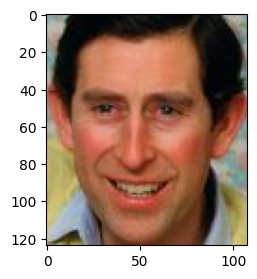

In [5]:
def show_img(f):
  img = plt.imread(f)
  plt.figure(figsize=(4,3))
  plt.imshow(img)

show_img('family/dad/P06260_face5.jpg')

### Princess Diana

Now, let's view an image of Princess Diana:

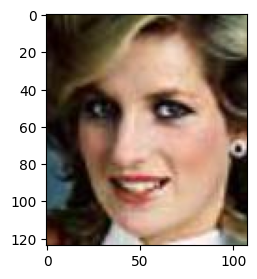

In [6]:
show_img('family/mom/P04407_face2.jpg')

### Prince William

And here's an image of Prince William:

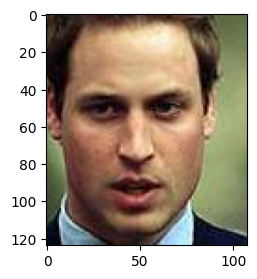

In [7]:
show_img('family/child/P04414_face1.jpg')

## Setting Up Pinecone

Now, let's set up Pinecone. We'll create our index name and establish a connection with Pinecone:

In [8]:
MODEL = 'Facenet'
INDEX_NAME = 'facenet'

pinecone = Pinecone(api_key=PINECONE_API_KEY)

## Generating Vector Embeddings

To generate the vector embeddings, we'll use DeepFace. First, we'll create embeddings for a single image to understand the process:

In [9]:
img_embed = DeepFace.represent(
    img_path='family/child/P04414_face1.jpg',
    model_name=MODEL,
    enforce_detection=False
)[0]['embedding']
print(
    f"\n\n#Embed\nEmbed: {img_embed[:10]}\nLength: {len(img_embed)}"
)

24-02-13 21:32:15 - facenet_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5
100%|██████████| 92.2M/92.2M [00:01<00:00, 51.9MB/s]


Embed: [-1.1709092855453491, 0.3168727159500122, -1.3733747005462646, 0.6241610646247864, -0.4635395109653473, 0.6284139156341553, 1.0436005592346191, 1.0136234760284424, 0.06262238323688507, -1.0429729223251343]
Length: 128


We're going to remove the file just to keep things clean. So what we're going to do is open up the file, we're going glob all of the images of each of the people separately, and then we're going to create embeddings out of each person's face and write it to disk. And the way that we're going to write it to disk inside of that vectors vec file is person, the image name, and then the embedding value itself.

In [10]:
def generate_vectors():
  VECTOR_FILE = "./vectors.vec"

  with contextlib.suppress(FileNotFoundError):
    os.remove(VECTOR_FILE)
  with open(VECTOR_FILE, "w") as f:
    for person in ["mom", "dad", "child"]:
      print(f"Files from: {person}")
      files = glob.glob(f'family/{person}/*')
      for file in tqdm(files):
        try:
          embedding = DeepFace.represent(img_path=file, model_name=MODEL, enforce_detection=False)[0]['embedding']
          f.write(f'{person}:{os.path.basename(file)}:{embedding}\n')
        except (ValueError, UnboundLocalError, AttributeError) as e:
          print(e)

generate_vectors()

100%|██████████| 93/93 [00:47<00:00,  1.97it/s]


This process will allow us to use the generated embeddings for facial similarity search.


<!--  -->

## Exploring Vector Embeddings

Let's examine the contents of the `vectors.vec` file after generating vector embeddings for the images. We'll use the `head` command to display the first few lines of the file:

In [13]:
!head -10 vectors.vec
# !head 10 vectors.vec

mom:P11984_face0.jpg:[-0.9805433750152588, -0.08096831291913986, 0.13421130180358887, -0.6833779215812683, 0.008803606033325195, 0.1694067269563675, 0.9354190230369568, 0.8994193077087402, 1.0125795602798462, -0.10070089995861053, 0.49330514669418335, 0.14516451954841614, -0.3328601121902466, -1.661919116973877, -0.5633184909820557, 0.9877188801765442, 0.6933419704437256, 0.710574746131897, -0.032929614186286926, -1.116885781288147, 1.1620666980743408, -1.127590298652649, -0.5329476594924927, -0.905417263507843, -1.4004055261611938, -0.20215639472007751, 1.2129031419754028, -1.0703270435333252, -0.6536792516708374, 0.9124642610549927, -0.18093888461589813, -1.1749186515808105, 1.533965826034546, -0.6854128241539001, 0.8274516463279724, -0.23010045289993286, 1.2768146991729736, 0.35292425751686096, -0.6774699687957764, 0.0661018043756485, 0.3721352517604828, -0.49911051988601685, -0.008498594164848328, -0.02660622075200081, -0.06051872670650482, 0.5229951739311218, 1.4106926918029785, -

Now that we have our embeddings, we'll proceed to calculate scores and upload data into Pinecone. Before uploading, let's visualize the embeddings using a scatter plot based on PCA reduction.

### Understanding PCA and t-SNE

Principal Component Analysis (PCA) is a technique used to reduce the dimensionality of data. It transforms a large set of variables into a smaller set while retaining most of the information. This reduction is particularly useful for high-dimensional datasets like embeddings.

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a dimensionality reduction technique primarily used for visualizing high-dimensional data in a lower-dimensional space, typically two or three dimensions. It helps reveal patterns, clusters, and relationships in complex datasets.

Let's create a function called `gen_tsne_df` to generate a t-SNE dataframe for a specific person:

In [20]:
def gen_tsne_df(person, perplexity):
    vectors =[]
    with open('./vectors.vec', 'r') as f:
      for line in tqdm(f):
        p, orig_img, v = line.split(':')
        if person == p:
            vectors.append(eval(v))
    pca = PCA(n_components=8)
    tsne = TSNE(2, perplexity=perplexity, random_state = 0, n_iter=1000,
        verbose=0, metric='euclidean', learning_rate=75)
    print(f'transform {len(vectors)} vectors')
    pca_transform = pca.fit_transform(vectors)
    embeddings2d = tsne.fit_transform(pca_transform)
    return pd.DataFrame({'x':embeddings2d[:,0], 'y':embeddings2d[:,1]})

This function iterates through the `vectors.vec` file, collects embeddings for a specific person, performs PCA reduction, and then applies t-SNE reduction to generate a two-dimensional dataframe.

### Visualizing Embeddings with t-SNE

And then what we do is actually do a PCA reduction against a specific person. So what we're doing here is a PCA reduction for a specific person who's passed into the function. Then we do a TSNE reduction as well against that, and return that as a data frame to the next function, which we're going to call here called `plot_tsne`.

And I'm going to go ahead and plug that in. So plot TSNI actually calls generate TSNe data frame. And you can see it down here below. And most of this code is just setting up matplotlib. And what we're going to do here, and this is the meat of it, is for each person that we've defined here in this, this dictionary.

Now, let's create a function called `plot_tsne` to plot the t-SNE scatter plot:

In [21]:
def plot_tsne(perplexity, model):
    (_, ax) = plt.subplots(figsize=(8,5))
    #plt.style.use('seaborn-whitegrid')
    plt.grid(color='#EAEAEB', linewidth=0.5)
    ax.spines['top'].set_color(None)
    ax.spines['right'].set_color(None)
    ax.spines['left'].set_color('#2B2F30')
    ax.spines['bottom'].set_color('#2B2F30')
    colormap = {'dad':'#ee8933', 'child':'#4fad5b', 'mom':'#4c93db'}

    for person in colormap:
        embeddingsdf = gen_tsne_df(person, perplexity)
        ax.scatter(embeddingsdf.x, embeddingsdf.y, alpha=.5,
                   label=person, color=colormap[person])
    plt.title(f'Scatter plot of faces using {model}', fontsize=16, fontweight='bold', pad=20)
    plt.suptitle(f't-SNE [perplexity={perplexity}]', y=0.92, fontsize=13)
    plt.legend(loc='best', frameon=True)
    plt.show()

This function sets up the plot style, iterates through each person to generate t-SNE data, and plots the scatter plot accordingly.

### Plotting t-SNE Scatter Plot

Let's visualize the embeddings using the `plot_tsne` function with a perplexity of 44:

241it [00:00, 9250.14it/s]


transform 70 vectors


241it [00:00, 6026.59it/s]


transform 93 vectors


241it [00:00, 8626.50it/s]


transform 78 vectors


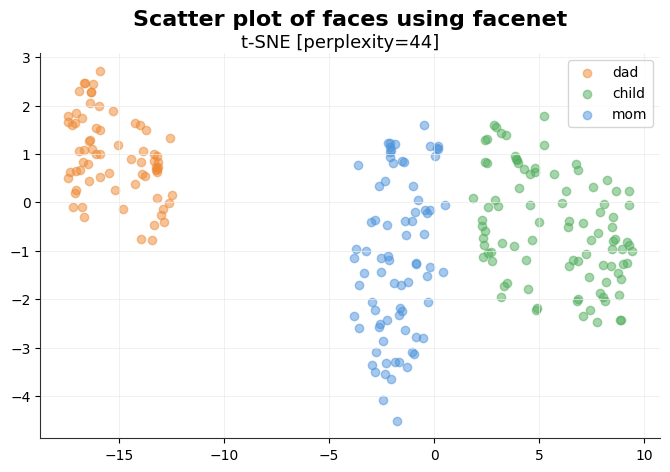

In [22]:
plot_tsne(44, 'facenet')

Feel free to experiment with different perplexity values to observe changes in the scatter plot.


<!--  -->
## Clustering Analysis and Pinecone Setup

Upon examining the scatter plot of the embeddings, it's evident that the images of each family member—dad, child, and mom—cluster together. However, it's important to exercise caution when interpreting the proximity of the child and mom clusters. While they may appear close in the plot, it's not necessarily indicative of strong similarities between them.

In [18]:

for index in pinecone.list_indexes():
  pinecone.delete_index(index.name)


pinecone.create_index(
    name=INDEX_NAME, dimension=128, metric='cosine',
    spec=PodSpec(
        environment='us-west1-gcp',
        pod_type='p1.x1'
    )
)

index = pinecone.Index(INDEX_NAME)

We proceed by setting up Pinecone to store our embeddings. First, we ensure a clean slate by deleting any existing index and then create a new one with the specified dimensions and metric.

In [23]:
def store_vectors():
  with open("vectors.vec", "r") as f:
    for line in tqdm(f):
        person, file, vec = line.split(':')
        index.upsert([
            (f'{person}-{file}', eval(vec), {"person":person, "file":file})
            ])
store_vectors()

index.describe_index_stats()

241it [00:14, 16.24it/s]


{'dimension': 128,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 241}},
 'total_vector_count': 241}

<!--  -->

## Computing Similarity Scores and Finding Closest Image

Now, let's compute the similarity scores between each parent (dad and mom) and the child (Prince William).

First, we define a function `test` to calculate the average similarity score between a parent and the child. This function takes groups of vectors for each parent and the child, queries Pinecone to find similar images of the child given the parent's vectors, and computes the average score.

In [24]:
def test(vec_groups, parent, child):
  index = pinecone.Index(INDEX_NAME)
  parent_vecs = vec_groups[parent]
  K = 10
  SAMPLE_SIZE = 10
  sum = 0
  for i in tqdm(range(0,SAMPLE_SIZE)):
    query_response = index.query(
      top_k=K,
      vector = parent_vecs[i],
      filter={
        "person": {"$eq": child}
      }
    )
    for row in query_response["matches"]:
      sum  = sum + row["score"]
  print(f'\n\n{parent} AVG: {sum / (SAMPLE_SIZE*K)}')

Then, we define a function `compute_scores` to organize the vectors into groups for each parent and the child and call the `test` function for both parents.

In [25]:
def compute_scores():
  index = pinecone.Index(INDEX_NAME)
  vec_groups = {"dad":[], "mom":[], "child":[]}
  with open("vectors.vec", "r") as f:
    for line in tqdm(f):
      person, file, vec = line.split(':')
      vec_groups[person].append(eval(vec))
  print(f"DAD {'-' * 20}")
  test(vec_groups, "dad", "child")
  print(f"MOM {'-' * 20}")
  test(vec_groups, "mom", "child")

compute_scores()

241it [00:00, 2793.73it/s]


DAD --------------------


100%|██████████| 10/10 [00:00<00:00, 61.57it/s]




dad AVG: 0.44659371646
MOM --------------------


100%|██████████| 10/10 [00:00<00:00, 78.83it/s]



mom AVG: 0.3455488734099999


These functions compute and display the average similarity scores between the parents and the child.

Next, we find the closest image of Prince William among those that resemble his dad the most.

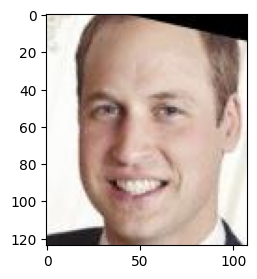

In [26]:
child_base = 'family/child/P06310_face1.jpg'
show_img(child_base)

In [27]:
embedding = DeepFace.represent(img_path=child_base, model_name=MODEL)[0]['embedding']
print(embedding)

[0.5283989906311035, 1.2861864566802979, -0.35614562034606934, -1.0126630067825317, 0.9982870221138, 0.6666176319122314, 0.5679237842559814, 1.6064079999923706, 0.1469832956790924, -0.5307552218437195, 0.33921512961387634, -1.0853039026260376, -0.7407265901565552, -1.2022422552108765, -0.24404257535934448, -0.4366186261177063, -1.6220470666885376, -2.924757480621338, -0.35454729199409485, -0.24917593598365784, 0.030634626746177673, -0.21422120928764343, -0.4420793950557709, -0.31803250312805176, -0.4128802716732025, -0.3246876299381256, 1.1288135051727295, 0.46149682998657227, -0.8908524513244629, 0.5013216733932495, -1.8914414644241333, -0.10036247968673706, -2.004007339477539, -0.5636603236198425, 0.4059157967567444, -0.5800120830535889, -1.518979787826538, -1.6227506399154663, 1.5995073318481445, -0.3009588420391083, -0.9496643543243408, -1.9736125469207764, -2.5460355281829834, -0.24491317570209503, 1.734770655632019, -1.6264370679855347, 1.3015145063400269, 0.9842946529388428, 0.8

We query Pinecone to find the top three closest images of Prince William's dad and display the metadata of the closest match.

In [28]:
query_response = index.query(
      top_k=3,
      vector = embedding,
      filter={
        "person": {"$eq": "dad"}
      },
      include_metadata=True
)

print(query_response)

{'matches': [{'id': 'dad-P06396_face3.jpg',
              'metadata': {'file': 'P06396_face3.jpg', 'person': 'dad'},
              'score': 0.438557684,
              'values': []},
             {'id': 'dad-P11886_face3.jpg',
              'metadata': {'file': 'P11886_face3.jpg', 'person': 'dad'},
              'score': 0.419384658,
              'values': []},
             {'id': 'dad-P04408_face0.jpg',
              'metadata': {'file': 'P04408_face0.jpg', 'person': 'dad'},
              'score': 0.407050788,
              'values': []}],
 'namespace': ''}


Finally, we display the image that is most similar to Prince William among those of his dad.

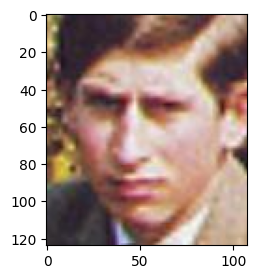

In [29]:
photo = query_response["matches"][0]["metadata"]["file"]
show_img(f"family/dad/{photo}")

In conclusion, this system helps determine which parent—King Charles or Princess Diana—looks most like their offspring, Prince William. The data suggests that King Charles bears a closer resemblance to Prince William. Further, we identify the image of King Charles that is most similar to Prince William, providing insights into familial similarities.


<!--  -->